# **LifeHarmony: An AI Recommender System for a Balanced Life**

After generating a logically consistent dataset based on behavioral features and priorities, it's now time to train our model. This step leverages the structured data to predict personalized recommendations for users based on their attributes and priorities.

Our model focuses on learning:
- **High Priority Recommendations**: Critical suggestions tailored to address the most significant gaps in a user's life domains.

The training process uses structured logical relations and dataset features to map user attributes to actionable suggestions, ensuring each recommendation is practical, relevant, and aligned with the user's needs.

---

## **Overview of Dataset Features and True Labels**

The dataset contains the following **features** and **true labels**:

### **Features**
1. **User Attributes**:
   - `UserID`: A unique identifier for each user.
   - `Age`: The user's age (scaled for better model performance).
   - `Gender`: The user's gender.
   - `Marital Status`: Single or Married status of the user.
   - `Occupation`: User's occupation (e.g., Full-time, Freelancer, Student, etc.).
   - `Budget`: Budget allocated for personal development (scaled for the model).
   - `Time Allocated (hrs/week)`: Weekly hours dedicated to personal growth.
   - `Personality`: User's personality type (Introvert, Extrovert, Ambivert).
   - `Hobbies`: User's primary hobby or interest (e.g., Reading, Art, Exercise, etc.).

2. **Domain Priorities**:
   - `Career_Priority`: Importance of career-related improvements (High/Medium/Low).
   - `Financial_Priority`: Importance of financial stability (High/Medium/Low).
   - `Spiritual_Priority`: Importance of spiritual growth (High/Medium/Low).
   - `Physical_Priority`: Importance of physical well-being (High/Medium/Low).
   - `Intellectual_Priority`: Importance of intellectual development (High/Medium/Low).
   - `Family_Priority`: Importance of family-related improvements (High/Medium/Low).
   - `Social_Priority`: Importance of social connections (High/Medium/Low).
   - `Fun_Priority`: Importance of fun and recreational activities (High/Medium/Low).

### **True Label**
**High Priority Recommendations**:
   - A list of actionable suggestions addressing the user's most urgent priorities (e.g., "Update your resume", "Start an emergency savings plan").
   - Each recommendation aligns with the user's high-priority domains and attributes like budget, hobbies, and occupation.

---

### **Key Example**
| **Feature**              | **Example Value**         |  
|--------------------------|---------------------------|  
| `Age`                   | 32                        |  
| `Gender`                | Female                    |  
| `Marital Status`        | Married                   |  
| `Occupation`            | Freelancer                |  
| `Budget`                | 1375                      |  
| `Personality`           | Extrovert                 |  
| `Career_Priority`       | High                      |  
| **High Priority Recommendations** | ["Update your resume", "Attend career fairs"] |  

This dataset forms the foundation for training a multi-label model that predicts recommendations aligned with user attributes and domain priorities.


In [6]:
import numpy as np
import pandas as pd

# Load the dataset
data_path = "generated_datasets/4_generated_dataset_with_recommendations.xlsx"
data = pd.read_excel(data_path)

In [7]:
# Subsample the dataset
subsample_data = data.sample(n=12000, random_state=37)

# **Data Preprocessing and Encoding**

Before training, the raw dataset must be preprocessed and encoded for model compatibility. This involves:

1. **Categorical Encoding**: Mapping categorical variables like `Personality`, and `Occupation` to numeric values.
2. **Priority Scaling**: Converting priority levels (`High`, `Medium`, `Low`) into numerical scales for training.
3. **Feature Normalization**: Scaling continuous variables like `Age` and `Budget` to enhance model performance.

Key Steps:
- One-hot encoding for features like `Hobbies`.
- Numerical mapping for priorities and personality traits.
- Data splitting into training, validation, and test sets.

In [9]:
marital_status_mapping = {"Single": 0, "Married": 1}
occupation_mapping = {"Full-time": 0, "Part-time": 1, "Freelancer": 2, "Student": 3, "Unemployed": 4}
personality_mapping = {"Extrovert": 0, "Introvert": 1, "Ambivert": 2}
hobby_mapping = {"Exercise": 0, "Reading": 1, "Writing": 2, "Art": 3, "Socializing": 4}
priority_mapping = {"Low": 0, "Medium": 1, "High": 2}

life_features = ["Career", "Financial", "Spiritual", "Physical", "Intellectual", "Family", "Social", "Fun"]

In [10]:
# Define RL Environment for subsampled data
# Encode training states
encoded_states = []
for _, row in subsample_data.iterrows():
    encoded_state = [
        int(row['Age']),
        marital_status_mapping[row['Marital Status']],
        occupation_mapping[row['Occupation']],
        int(row['Budget']),
        personality_mapping[row['Personality']],
        hobby_mapping[row['Hobbies']],
        priority_mapping[row['Career_Priority']],
        priority_mapping[row['Financial_Priority']],
        priority_mapping[row['Spiritual_Priority']],
        priority_mapping[row['Physical_Priority']],
        priority_mapping[row['Intellectual_Priority']],
        priority_mapping[row['Family_Priority']],
        priority_mapping[row['Social_Priority']],
        priority_mapping[row['Fun_Priority']],
    ]
    encoded_states.append(encoded_state)

# Convert to NumPy array for RL model training
states = np.array(encoded_states)

actions = subsample_data['Recommendations'].apply(eval).values  # Actions (recommendations)

num_actions = len(set(sum(actions, [])))  # Unique recommendations

from sklearn.model_selection import train_test_split

# Split the states and actions
train_states, val_states, train_actions, val_actions = train_test_split(
    states, actions, test_size=0.2, random_state=42
)

num_train_states = len(train_states)
num_test_states = len(val_states)

# Initialize separate Q-tables for training and validation
####  Initialize Q-values randomly within a small range to encourage exploration:
train_q_table = np.random.uniform(low=0, high=0.01, size=(len(train_states), num_actions))
val_q_table = np.zeros((num_test_states, num_actions))

# Print subsampled info
print("Number of Unique Training Samples:", num_train_states)
print("Number of Unique Testing Samples:", num_test_states)
print("Number of Unique Recommendations in Training Set:", len(set(sum(train_actions, []))))
print("Number of Unique Recommendations in Testing Set:", len(set(sum(val_actions, []))))
print("Number of Unique Recommendations in Total:", num_actions)
# Assuming `encoded_training_states` is your array of training state vectors
np.save("encoded_training_states.npy", train_states)
print("Training states saved!")



Number of Unique Training Samples: 9600
Number of Unique Testing Samples: 2400
Number of Unique Recommendations in Training Set: 40
Number of Unique Recommendations in Testing Set: 40
Number of Unique Recommendations in Total: 40
Training states saved!


# **Reinforcement Learning: Training the Q-Table**

Using a Q-learning approach to map user states (attributes and priorities) to actionable recommendations:

1. **State Representation**: Encoded states based on user attributes and domain priorities.
2. **Actions**: A pool of potential recommendations.
3. **Reward Function**:
   - Positive rewards for actionable recommendations that align with user priorities.
   - Negative rewards for irrelevant or impractical suggestions.

### **Parallel Processing for Efficient Training**
To accelerate the training process, **parallel processing** is utilized:
- Each state in the dataset is processed independently during each Q-value update.
- This independence enables the use of libraries like `joblib` to distribute computations across multiple CPU cores.

### **Advantages of Parallel Training**
- **Speed**: Significantly reduces training time for large datasets.
- **Scalability**: Handles high-dimensional data and extensive state-action spaces efficiently.
- **Reproducibility**: Ensures consistent updates across parallel tasks using shared data structures.

#### Example Workflow
1. **Initialize Q-Table**: Assign initial Q-values to all state-action pairs.
2. **Process States in Parallel**:
   - Use the `joblib` library to distribute the workload.
   - Update Q-values for each state independently.
3. **Combine Updates**:
   - Aggregate Q-values after each iteration.
   - Ensure consistent learning rate (`alpha`) and discount factor (`gamma`) across states.
4. **Repeat**: Iterate until convergence.

This approach ensures the model scales effectively with increasing data while maintaining consistency in policy learning.


Number of Unique Actions in Training Set: 40


Training Progress:   7%|▋         | 100/1500 [03:34<49:38,  2.13s/iteration]

Iteration 100: Avg Reward = 30.75116786362738, Avg Q-value = 0.8396968080220061, Epsilon = 0.901
Precision = 0.5430, Recall = 0.4661, F1 = 0.4614
--------------------------------------------------


Training Progress:  13%|█▎        | 200/1500 [07:11<45:27,  2.10s/iteration]

Iteration 200: Avg Reward = 28.00806629741582, Avg Q-value = 1.6428442578277236, Epsilon = 0.8009999999999999
Precision = 0.9487, Recall = 0.7877, F1 = 0.8429
--------------------------------------------------


Training Progress:  20%|██        | 300/1500 [10:51<44:24,  2.22s/iteration]

Iteration 300: Avg Reward = 25.3011112196433, Avg Q-value = 2.4221092926960672, Epsilon = 0.7010000000000001
Precision = 0.9992, Recall = 0.9624, F1 = 0.9784
--------------------------------------------------


Training Progress:  27%|██▋       | 400/1500 [14:30<40:26,  2.21s/iteration]

Iteration 400: Avg Reward = 22.63460194830537, Avg Q-value = 3.167502155314621, Epsilon = 0.601
Precision = 1.0000, Recall = 0.9989, F1 = 0.9994
--------------------------------------------------


Training Progress:  33%|███▎      | 500/1500 [18:05<35:49,  2.15s/iteration]

Iteration 500: Avg Reward = 20.109196568436822, Avg Q-value = 3.861665108864901, Epsilon = 0.501
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  40%|████      | 600/1500 [21:37<31:30,  2.10s/iteration]

Iteration 600: Avg Reward = 17.752659719139203, Avg Q-value = 4.486317648872489, Epsilon = 0.401
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  47%|████▋     | 700/1500 [25:07<28:23,  2.13s/iteration]

Iteration 700: Avg Reward = 15.659972712961029, Avg Q-value = 5.025389044002811, Epsilon = 0.30099999999999993
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  53%|█████▎    | 800/1500 [28:35<23:18,  2.00s/iteration]

Iteration 800: Avg Reward = 13.852438432985863, Avg Q-value = 5.464044508765216, Epsilon = 0.20099999999999996
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  60%|██████    | 900/1500 [31:57<23:19,  2.33s/iteration]

Iteration 900: Avg Reward = 12.376293006439358, Avg Q-value = 5.790510634622899, Epsilon = 0.10099999999999998
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  67%|██████▋   | 1000/1500 [35:29<17:14,  2.07s/iteration]

Iteration 1000: Avg Reward = 11.344079726684601, Avg Q-value = 6.044968965839757, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  73%|███████▎  | 1100/1500 [39:41<21:21,  3.20s/iteration]

Iteration 1100: Avg Reward = 10.431664039238093, Avg Q-value = 6.277480700995973, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  80%|████████  | 1200/1500 [43:49<10:33,  2.11s/iteration]

Iteration 1200: Avg Reward = 9.634084192377124, Avg Q-value = 6.490145201333715, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  87%|████████▋ | 1300/1500 [47:21<07:16,  2.18s/iteration]

Iteration 1300: Avg Reward = 8.928274099601238, Avg Q-value = 6.684332370521799, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress:  93%|█████████▎| 1400/1500 [50:54<03:33,  2.13s/iteration]

Iteration 1400: Avg Reward = 8.31540442650014, Avg Q-value = 6.861483100719679, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------


Training Progress: 100%|██████████| 1500/1500 [54:28<00:00,  2.18s/iteration]

Iteration 1500: Avg Reward = 7.767617569945843, Avg Q-value = 7.022559697044535, Epsilon = 0.1
Precision = 1.0000, Recall = 1.0000, F1 = 1.0000
--------------------------------------------------

Q-learning Complete
Q-table saved.


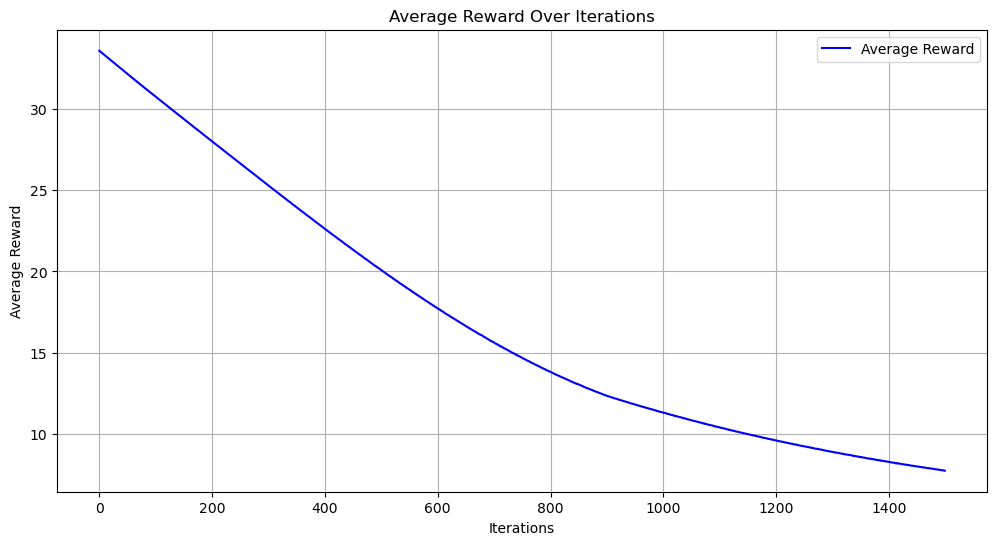

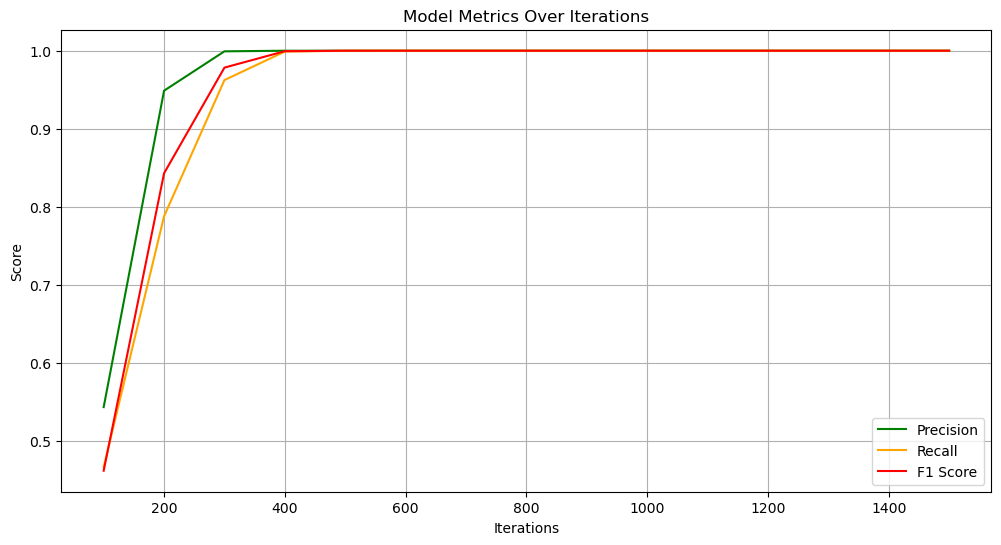

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# Map actions to indices
unique_actions = list(set(sum(train_actions, [])))  # Flatten and get unique actions
action_to_index = {action: idx for idx, action in enumerate(unique_actions)}
index_to_action = {idx: action for action, idx in action_to_index.items()}
num_actions = len(unique_actions)

print("Number of Unique Actions in Training Set:", num_actions)

# Initialize training Q-table
train_q_table = np.zeros((len(train_states), num_actions))

# Check for invalid actions
for state_idx, state_actions in enumerate(train_actions):
    for action in state_actions:
        if action not in action_to_index:
            print(f"Action {action} not in action_to_index mapping (State {state_idx})")

# Define a custom reward function
def simulate_reward(state_actions, action, q_table, action_idx):
    """
    Calculate reward based on action relevance.
    Diminishing rewards for repeated recommendations using Q-table.
    """
    if action in state_actions:
        return 5 - 0.5 * q_table[:, action_idx].mean()  # Diminishing reward for overused actions
    else:
        return -5  # Penalize irrelevant actions

# Exploration probability (epsilon)
initial_epsilon = 1.0  # Start with full exploration
min_epsilon = 0.1  # Minimum exploration
epsilon_decay = 0.001  # Decay rate

# Define a single training step for a state
def train_state(state_idx, q_table, actions, learning_rate, gamma, epsilon):
    """
    Update Q-table row for a specific state.
    """
    new_row = q_table[state_idx].copy()  # Copy current Q-values
    total_reward = 0  # To accumulate rewards for this state

    for action in actions[state_idx]:
        if np.random.random() < epsilon:  # Explore
            action_idx = np.random.choice(len(action_to_index))
        else:  # Exploit
            action_idx = action_to_index[action]

        reward = simulate_reward(actions[state_idx], action, q_table, action_idx)
        next_state_idx = (state_idx + 1) % len(q_table)  # Sequential state transition
        max_future_q = np.max(q_table[next_state_idx])  # Best Q-value of next state

        # Q-learning update formula
        new_row[action_idx] = (
            (1 - learning_rate) * new_row[action_idx]
            + learning_rate * (reward + gamma * max_future_q)
        )
        total_reward += reward

    return new_row, total_reward


# Multi-label recommendation function
def get_recommendations(q_table, state_idx, threshold=0.9):
    """
    Return actions with Q-values above a certain threshold for a state.
    """
    state_q_values = q_table[state_idx]
    max_q_value = np.max(state_q_values)
    recommended_actions = [
        index_to_action[idx]
        for idx, q_val in enumerate(state_q_values)
        if q_val >= threshold * max_q_value
    ]
    return recommended_actions


# Evaluate Q-table predictions
def evaluate_predictions(q_table, states, true_actions, threshold=0.8):
    """
    Evaluate model performance using Precision, Recall, and F1 Score.
    """
    precision_list = []
    recall_list = []
    f1_list = []

    for state_idx in range(len(states)):
        predicted_actions = get_recommendations(q_table, state_idx, threshold)
        true_labels = true_actions[state_idx]

        true_positive = len(set(predicted_actions) & set(true_labels))
        precision = true_positive / len(predicted_actions) if predicted_actions else 0
        recall = true_positive / len(true_labels) if true_labels else 0
        f1_score = (
            2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        )

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    return avg_precision, avg_recall, avg_f1


# Parallel Q-learning on training data
learning_rate = 0.01
gamma = 0.9
num_iterations = 1500
rewards_log = []  # To log rewards
precision_log = []  # To log precision
recall_log = []  # To log recall
f1_log = []  # To log F1-score

# Progress bar for training iterations
progress_bar = tqdm(range(num_iterations), desc="Training Progress", unit="iteration")
for iteration in progress_bar:
    # Decay epsilon for exploration-exploitation balance
    epsilon = max(min_epsilon, initial_epsilon - epsilon_decay * iteration)

    # Parallelize training for all states
    results = Parallel(n_jobs=8)(
        delayed(train_state)(state_idx, train_q_table, train_actions, learning_rate, gamma, epsilon)
        for state_idx in range(len(train_states))
    )

    # Separate updated rows and iteration rewards
    updated_rows, iteration_rewards = zip(*results)
    train_q_table = np.array(updated_rows)  # Update Q-table
    avg_reward = np.mean(iteration_rewards)  # Calculate average reward
    rewards_log.append(avg_reward)

    # Evaluate precision, recall, and F1 every 100 iterations
    if (iteration + 1) % 100 == 0:
        precision, recall, f1_score = evaluate_predictions(train_q_table, train_states, train_actions)
        precision_log.append(precision)
        recall_log.append(recall)
        f1_log.append(f1_score)

        avg_q_value = np.mean(train_q_table)
        print(f"Iteration {iteration + 1}: Avg Reward = {avg_reward}, Avg Q-value = {avg_q_value}, Epsilon = {epsilon}")
        print(f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1_score:.4f}")
        print("-" * 50)
        

print("\nQ-learning Complete")
np.save("train_q_table.npy", train_q_table)
print("Q-table saved.")

# Plot metrics and reward evolution
plt.figure(figsize=(12, 6))
plt.plot(rewards_log, label="Average Reward", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Reward Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 6))
plt.plot(range(100, num_iterations + 1, 100), precision_log, label="Precision", color="green")
plt.plot(range(100, num_iterations + 1, 100), recall_log, label="Recall", color="orange")
plt.plot(range(100, num_iterations + 1, 100), f1_log, label="F1 Score", color="red")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.title("Model Metrics Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Save the index_to_action mapping to a file
np.save("index_to_action.npy", index_to_action)
print("Index-to-action mapping saved to 'index_to_action.npy'")


Index-to-action mapping saved to 'index_to_action.npy'


# **k-NN Matching for Validation States**

To validate the trained Q-Table's ability to generalize, we use k-Nearest Neighbors (k-NN) for state matching:

1. **State Encoding**: Ensure validation states are encoded identically to training states.
2. **k-NN Implementation**:
   - Match validation states to their closest training states.
   - Aggregate Q-values from the nearest neighbors to make predictions.
3. **Evaluation**:
   - **Precision**: Proportion of relevant recommendations among all predicted.
   - **Recall**: Proportion of correctly predicted recommendations among true recommendations.
   - **F1 Score**: Harmonic mean of precision and recall.

Results:
- Highlight precision, recall, and F1 score for various k and threshold values.


In [3]:
import numpy as np

k_neighbors = 10
threshold = 0.8
loaded_training_states = np.load("encoded_training_states.npy")
loaded_q_table = np.load("train_q_table.npy")
loaded_index_to_action = np.load("index_to_action.npy", allow_pickle=True).item() 

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors

def validate_policy_weighted_knn_metrics(
    q_table, 
    encoded_training_states, 
    val_states, 
    val_actions, 
    index_to_action, 
    threshold=threshold, 
    k=k_neighbors, 
    epsilon=1e-5
):
    """
    Validate policy using distance-weighted k-NN and compute precision, recall, and F1-score.
    """
    # Initialize k-NN
    knn = NearestNeighbors(n_neighbors=k, metric="cosine")
    knn.fit(encoded_training_states)
    
    # Initialize metrics
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    for state_idx, val_state in enumerate(val_states):
        # Find nearest neighbors
        distances, indices = knn.kneighbors(val_state.reshape(1, -1))
        closest_states = [idx for idx in indices[0] if idx < len(q_table)]  # Ensure valid indices

        # Calculate weights for neighbors
        weights = [1 / (dist + epsilon) for dist in distances[0]]

        # Aggregate Q-values with weights
        if closest_states:
            aggregated_q_values = np.zeros(q_table.shape[1])
            for idx, weight in zip(closest_states, weights):
                aggregated_q_values += weight * q_table[idx]
            
            # Normalize aggregated Q-values
            aggregated_q_values /= np.sum(weights)

            # Get actions above the threshold
            max_q_value = np.max(aggregated_q_values)
            optimal_actions = [
                index_to_action[action_idx]
                for action_idx in np.where(aggregated_q_values >= threshold * max_q_value)[0]
            ]

            # True actions for the state
            true_actions = val_actions[state_idx]

            # Compute true positives, false positives, and false negatives
            true_positives = len(set(optimal_actions) & set(true_actions))
            false_positives = len(set(optimal_actions) - set(true_actions))
            false_negatives = len(set(true_actions) - set(optimal_actions))

            total_true_positives += true_positives
            total_false_positives += false_positives
            total_false_negatives += false_negatives

    # Compute metrics
    precision = total_true_positives / (total_true_positives + total_false_positives) if total_true_positives + total_false_positives > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if total_true_positives + total_false_negatives > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall)
        if precision + recall > 0 else 0
    )

    return precision, recall, f1


# **Choosing Values for `k_neighbors` and `threshold`**

To balance the model's performance, we iterate over a range of values for:
- **`k_neighbors`**: The number of nearest neighbors to consider during k-NN.
- **`threshold`**: The Q-value threshold to filter recommendations.

The optimal combination balances precision, recall, and F1-score.

> **Note**: This block is disabled by default. You can enable it by setting `run_this_block = True`.

In [19]:
run_this_block = True  # Set to True to enable this block

if run_this_block:
    for k_neighbors in range(1,5):
        for threshold in range(7, 9):
            precision, recall, f1 = validate_policy_weighted_knn_metrics(
            q_table=loaded_q_table,
            encoded_training_states=loaded_training_states,
            val_states=val_states,
            val_actions=val_actions,
            index_to_action=loaded_index_to_action,
            threshold=threshold*0.1,
            k=k_neighbors 
            )
            
            print(f"At k = {k_neighbors}, threshold = {threshold*0.1}: ")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print("-"*50)

At k = 1, threshold = 0.7000000000000001: 
Precision: 0.7016, Recall: 0.7015, F1 Score: 0.7015
At k = 1, threshold = 0.8: 
Precision: 0.7016, Recall: 0.7015, F1 Score: 0.7015
--------------------------------------------------
At k = 2, threshold = 0.7000000000000001: 
Precision: 0.6787, Recall: 0.6554, F1 Score: 0.6668
At k = 2, threshold = 0.8: 
Precision: 0.8118, Recall: 0.5220, F1 Score: 0.6354
--------------------------------------------------
At k = 3, threshold = 0.7000000000000001: 
Precision: 0.7159, Recall: 0.7363, F1 Score: 0.7259
At k = 3, threshold = 0.8: 
Precision: 0.7973, Recall: 0.5792, F1 Score: 0.6710
--------------------------------------------------
At k = 4, threshold = 0.7000000000000001: 
Precision: 0.7181, Recall: 0.7473, F1 Score: 0.7324
At k = 4, threshold = 0.8: 
Precision: 0.8009, Recall: 0.6225, F1 Score: 0.7005
--------------------------------------------------


In [24]:
# best parameters for our model to give good list of recommendations to user without overwhelming them with too many
k = 3
threshold = 0.7

precision, recall, f1 = validate_policy_weighted_knn_metrics(
q_table=loaded_q_table,
encoded_training_states=loaded_training_states,
val_states=val_states,
val_actions=val_actions,
index_to_action=loaded_index_to_action,
threshold=threshold,
k=k_neighbors 
)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 0.7181, Recall: 0.7473, F1 Score: 0.7324


# **Recommendations for a Validation State**

After training, the system generates personalized recommendations for validation states. Here’s an example:

### **Validation State**
- Encoded Attributes: [42, 0, 3, 167, 2, 1, 0, 0, 1, 2, 1, 0, 2, 2]

### **True Actions**
- Exercise regularly
- Use affordable fitness apps
- Eat healthy foods
- Attend regular preventative medical checkups
- Try community hikes or dance classes
- Join small, interest-based groups
- Participate in online communities
- Engage in hobbies you enjoy
- Watch your favorite shows

### **Predicted Actions**
- Build an emergency savings fund
- Engage in hobbies you enjoy
- Start tracking weekly expenses using an app
- Eat healthy foods
- Exercise regularly
- ...

### **Comparison**
- **Correct Predictions**: Exercise regularly, Eat healthy foods, Participate in online communities
- **False Negatives**: Try community hikes, Watch your favorite shows
- **False Positives**: Build an emergency savings fund, Start tracking expenses

This analysis helps refine the model by adjusting thresholds, weights, or k-NN parameters.


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Define necessary variables
# Assuming these are loaded or generated beforehand:
train_q_table = np.load("train_q_table.npy")  # Your Q-table
encoded_training_states = np.load("encoded_training_states.npy")  # Encoded training states
index_to_action = np.load("index_to_action.npy", allow_pickle=True).item()  # Mapping of indices to actions

# Initialize k-NN
k = k_neighbors
knn = NearestNeighbors(n_neighbors=k, metric="cosine")
knn.fit(encoded_training_states)

# Select a specific validation state
state_idx = 0  # Index of the validation state to analyze *******************************
val_state = val_states[state_idx]
true_actions = val_actions[state_idx]

# Get predicted actions using k-NN
distances, indices = knn.kneighbors(val_state.reshape(1, -1))
closest_states = [idx for idx in indices[0] if idx < len(train_q_table)]  # Valid indices

# Aggregate Q-values for neighbors
aggregated_q_values = np.mean([train_q_table[idx] for idx in closest_states], axis=0)
max_q_value = np.max(aggregated_q_values)

# Predicted actions based on the threshold
threshold = threshold
predicted_actions = [
    index_to_action[action_idx]
    for action_idx in np.where(aggregated_q_values >= threshold * max_q_value)[0]
]

# Display the real data
print(f"Validation State {state_idx}:")
print(f"Encoded State Vector: {val_state.tolist()}")


print("\nTrue Actions:")
for action in true_actions:
    print(f"- {action}")

print("\nPredicted Actions:")
for action in predicted_actions:
    print(f"- {action}")

# Compare true and predicted actions
common_actions = set(true_actions) & set(predicted_actions)
missing_actions = set(true_actions) - set(predicted_actions)
extra_actions = set(predicted_actions) - set(true_actions)

print("\nComparison:")
print(f"Common Actions (Correctly Predicted): {list(common_actions)}")
print(f"Missing Actions (False Negatives): {list(missing_actions)}")
print(f"Extra Actions (False Positives): {list(extra_actions)}")


Validation State 0:
Encoded State Vector: [42, 0, 3, 167, 2, 1, 0, 0, 1, 2, 1, 0, 2, 2]

True Actions:
- Exercise regularly
- Use affordable fitness apps
- Eat healthy foods
- Attend regular preventative medical checkups
- Try community hikes or dance classes
- Join small, interest-based groups
- Participate in online communities
- Engage in hobbies you enjoy
- Watch your favorite shows

Predicted Actions:
- Engage in hobbies you enjoy
- Eat healthy foods
- Exercise regularly
- Participate in online communities
- Use affordable fitness apps
- Try community hikes or dance classes
- Attend regular preventative medical checkups
- Join small, interest-based groups
- Watch your favorite shows

Comparison:
Common Actions (Correctly Predicted): ['Exercise regularly', 'Attend regular preventative medical checkups', 'Eat healthy foods', 'Engage in hobbies you enjoy', 'Try community hikes or dance classes', 'Participate in online communities', 'Watch your favorite shows', 'Use affordable fitness

# **Limitations, Future Improvements, and Conclusion**

---

## **Limitations**

1. **Simplistic Dataset**:
   - The generated dataset, while logically consistent, may not fully capture the complexity of real-world scenarios.
   - Behavioral nuances and cultural variations might be underrepresented.

2. **Dependence on K-NN for Generalization**:
   - While the k-NN algorithm helps with state matching, it may overgeneralize or underfit in certain cases, especially with edge cases or sparse data.
   - The model's effectiveness heavily relies on the quality of encoded features and their distance metrics.

---

## **Future Improvements**

1. **Dynamic Learning and Real-World Feedback**:
   - Incorporate live user feedback to continuously fine-tune recommendations and adjust priorities.
   - Implement reinforcement learning with continuous updates to the Q-table based on real-world user interactions.

2. **Context-Aware Recommendations**:
   - Integrate contextual data (e.g., time of year, geographic location) to provide more situationally appropriate recommendations.
   - Include temporal factors to prioritize short-term vs. long-term actions.

---

## **Conclusion**

The **LifeHarmony Recommender System** demonstrates the potential of combining reinforcement learning and k-NN-based state matching to provide tailored recommendations. By aligning user attributes and priorities with actionable suggestions, the system offers a pathway to a more balanced and fulfilling life.

While the current implementation achieves promising results with an **F1 score of 0.7324**, further refinements can improve its robustness and applicability. Addressing the outlined limitations and leveraging real-world feedback will be crucial for future iterations. With continuous development, the system has the potential to become a powerful tool for personal growth and well-being. 

--- 
